In [2]:
from ml_model.data import get_data
from sklearn import set_config; set_config(display='diagram')
import pandas as pd
%load_ext autoreload
%autoreload 2

In [3]:
fname = './ml_model/data/database_with_artifical_values.csv'

X_train, X_test, y_train, y_test = get_data(fname)

In [4]:
X_train

,Project Id,Armour Type,Armour Slope [v:h],Armour Density [kg/m3],Armour Mass [kg],Water Density [kg/m3],Offshore Significant Wave Height [m],Offshore Bed Elevation [m Datum],Average slope between offshore wave location and in front of Section [v:h],Significant Wave Height at Toe [m],Bed Elevation at Toe [m Datum],Peak Wave Period [s],Number of Waves [-],Crest Level [m Datum],Water Level [ m Datum],Notional Permeability [-]
Id,,,,,,,,,,,,,,,,
5223,-1,XBLOCK,3:04,2350.0,840.501356,1030,2.000000,-50.000000,1:1000,4.000000,-29.000000,8.000000,1000,10.000000,0.0,0.1
6740,-1,XBLOCK,3:04,2500.0,8851.327970,1030,5.000000,-50.000000,1:1000,8.750000,-36.000000,15.000000,1000,10.000000,0.0,0.1
3281,10,ROCK,1:03,2682.6,2000.000000,1020,2.732868,-20.150176,1:1000,2.732868,-20.150176,12.697404,1000,251.877200,0.0,0.1
6952,-1,XBLOCK,3:04,2500.0,88493.048090,1030,9.000000,-50.000000,1:1000,27.000000,-26.000000,12.000000,1000,10.000000,0.0,0.1
6987,-1,XBLOCK,3:04,2500.0,202316.067900,1030,10.000000,-50.000000,1:1000,50.000000,-38.000000,8.000000,1000,10.000000,0.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2758,10,ROCK,1:03,2682.6,180.000000,1020,1.145695,-9.030109,1:1000,1.145695,-9.030109,10.851856,3000,112.876368,0.0,0.1
4609,10,ROCK,01:01.5,2667.3,11931.558940,1020,5.675371,-36.615300,1:1000,5.675371,-36.615300,13.259965,1000,457.691248,0.0,0.5
887,10,ROCK,1:03,2682.6,22.000000,1020,0.649237,-4.481359,1:1000,0.649237,-4.481359,5.135936,1000,56.016988,0.0,0.1


In [5]:
X_train.columns

Index(['Project Id', 'Armour Type', 'Armour Slope [v:h]',
       'Armour Density [kg/m3]', 'Armour Mass [kg]', 'Water Density [kg/m3]',
       'Offshore Significant Wave Height [m]',
       'Offshore Bed Elevation [m Datum]',
       'Average slope between offshore wave location and in front of Section [v:h]',
       'Significant Wave Height at Toe [m]', 'Bed Elevation at Toe [m Datum]',
       'Peak Wave Period [s]', 'Number of Waves [-]', 'Crest Level [m Datum]',
       'Water Level [ m Datum]', 'Notional Permeability [-]'],
      dtype='object')

In [6]:
X_train['Armour Slope [v:h]']

Id
5223       3:04
6740       3:04
3281       1:03
6952       3:04
6987       3:04
         ...   
2758       1:03
4609    01:01.5
887        1:03
3082       1:04
781        1:02
Name: Armour Slope [v:h], Length: 4944, dtype: object

In [7]:
X_train['Armour Slope [v:h]'].apply(lambda row: float(row.split(':')[1]) / float(row.split(':')[0]))

Id
5223    1.333333
6740    1.333333
3281    3.000000
6952    1.333333
6987    1.333333
          ...   
2758    3.000000
4609    1.500000
887     3.000000
3082    4.000000
781     2.000000
Name: Armour Slope [v:h], Length: 4944, dtype: float64

In [8]:
#ohe armor type
#convert slope to cotangent
#relative density
#depth at toe
#structure height
ohe_columns = 'Armour Type'

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor


def convert_to_coteng(df):
    return pd.DataFrame(df['Armour Slope [v:h]'].apply(lambda row: float(row.split(':')[1]) / float(row.split(':')[0])))

num_transformer = Pipeline([
    ('scaler', RobustScaler())])

coteng_slope = FunctionTransformer(convert_to_coteng)
depth_toe = FunctionTransformer(lambda df: pd.DataFrame(df['Water Level [ m Datum]'] - df['Bed Elevation at Toe [m Datum]']))
structure_height = FunctionTransformer(lambda df: pd.DataFrame(df['Crest Level [m Datum]'] - df['Bed Elevation at Toe [m Datum]']))
relative_density = FunctionTransformer(lambda df: pd.DataFrame((df['Armour Density [kg/m3]'] - df['Water Density [kg/m3]']) / df['Water Density [kg/m3]']))

union_custom_transformer = FeatureUnion([
    ('coteng', coteng_slope),
    ('depth_toe', depth_toe),
    ('structure_height', structure_height),
    ('relative_density', relative_density)
])
    


custom_transformer = Pipeline([('union_custom_transformer',union_custom_transformer), 
          ('scaler_custom',RobustScaler())])
    


# # Encode categorical variables
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# # Paralellize "num_transformer" and "One hot encoder"
preprocessor = ColumnTransformer([
    ('num_tr', num_transformer, ['Armour Mass [kg]','Significant Wave Height at Toe [m]','Peak Wave Period [s]','Number of Waves [-]','Notional Permeability [-]']),
    ('cat_tr', cat_transformer, ['Armour Type']),
])

#union

preproc = FeatureUnion([
    ('preprocess', preprocessor), # columns 0-8
    ('custom_tr', custom_transformer) # new colums 9
])
preproc

FeatureUnion(transformer_list=[('preprocess',
                                ColumnTransformer(transformers=[('num_tr',
                                                                 Pipeline(steps=[('scaler',
                                                                                  RobustScaler())]),
                                                                 ['Armour Mass '
                                                                  '[kg]',
                                                                  'Significant '
                                                                  'Wave Height '
                                                                  'at Toe [m]',
                                                                  'Peak Wave '
                                                                  'Period [s]',
                                                                  'Number of '
                                                                  'Waves [-]',
                                                                  'Notional '
                                                                  'Permeability '
                                                                  '[-]']),
                                                                ('cat_tr',
                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                 ['Armour '
                                                                  'Type'])])),
                               ('custom_tr',
                                Pipel...
                                                                                 FunctionTransformer(func=<function convert_to_coteng at 0x7ffc6703de50>)),
                                                                                ('depth_toe',
                                                                                 FunctionTransformer(func=<function <lambda> at 0x7ffc63e63670>)),
                                                                                ('structure_height',
                                                                                 FunctionTransformer(func=<function <lambda> at 0x7ffc63bd7c10>)),
                                                                                ('relative_density',
                                                                                 FunctionTransformer(func=<function <lambda> at 0x7ffc63bd7ca0>))])),
                                                ('scaler_custom',
                                                 RobustScaler())]))])

In [10]:
# Add Estimator
pipe = make_pipeline(preproc, RandomForestRegressor())
pipe

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('preprocess',
                                                 ColumnTransformer(transformers=[('num_tr',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   RobustScaler())]),
                                                                                  ['Armour '
                                                                                   'Mass '
                                                                                   '[kg]',
                                                                                   'Significant '
                                                                                   'Wave '
                                                                                   'Height '
                                                                                   'at '
                                                                                   'Toe '
                                                                                   '[m]',
                                                                                   'Peak '
                                                                                   'Wave '
                                                                                   'Period '
                                                                                   '[s]',
                                                                                   'Number '
                                                                                   'of '
                                                                                   'Waves '
                                                                                   '[-]',
                                                                                   'Notional '
                                                                                   'Permeability '
                                                                                   '[-]']),
                                                                                 ('cat_tr',
                                                                                  OneHotEncoder(handle_unknown='...
                                                                                                  FunctionTransformer(func=<function convert_to_coteng at 0x7ffc6703de50>)),
                                                                                                 ('depth_toe',
                                                                                                  FunctionTransformer(func=<function <lambda> at 0x7ffc63e63670>)),
                                                                                                 ('structure_height',
                                                                                                  FunctionTransformer(func=<function <lambda> at 0x7ffc63bd7c10>)),
                                                                                                 ('relative_density',
                                                                                                  FunctionTransformer(func=<function <lambda> at 0x7ffc63bd7ca0>))])),
                                                                 ('scaler_custom',
                                                                  RobustScaler())]))])),
                ('randomforestregressor', RandomForestRegressor())])

In [11]:
# Train pipeline
pipe.fit(X_train,y_train)


Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('preprocess',
                                                 ColumnTransformer(transformers=[('num_tr',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   RobustScaler())]),
                                                                                  ['Armour '
                                                                                   'Mass '
                                                                                   '[kg]',
                                                                                   'Significant '
                                                                                   'Wave '
                                                                                   'Height '
                                                                                   'at '
                                                                                   'Toe '
                                                                                   '[m]',
                                                                                   'Peak '
                                                                                   'Wave '
                                                                                   'Period '
                                                                                   '[s]',
                                                                                   'Number '
                                                                                   'of '
                                                                                   'Waves '
                                                                                   '[-]',
                                                                                   'Notional '
                                                                                   'Permeability '
                                                                                   '[-]']),
                                                                                 ('cat_tr',
                                                                                  OneHotEncoder(handle_unknown='...
                                                                                                  FunctionTransformer(func=<function convert_to_coteng at 0x7ffc6703de50>)),
                                                                                                 ('depth_toe',
                                                                                                  FunctionTransformer(func=<function <lambda> at 0x7ffc63e63670>)),
                                                                                                 ('structure_height',
                                                                                                  FunctionTransformer(func=<function <lambda> at 0x7ffc63bd7c10>)),
                                                                                                 ('relative_density',
                                                                                                  FunctionTransformer(func=<function <lambda> at 0x7ffc63bd7ca0>))])),
                                                                 ('scaler_custom',
                                                                  RobustScaler())]))])),
                ('randomforestregressor', RandomForestRegressor())])

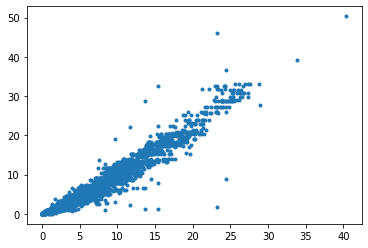

In [12]:
import matplotlib.pyplot as plt
plt.plot(pipe.predict(X_train),y_train, marker = '.', linewidth = 0)

In [13]:
pipe.score(X_train,y_train)

0.9394992174409341

In [14]:
pd.DataFrame(X_train['Armour Slope [v:h]'].apply(lambda row: float(row.split(':')[1]) / float(row.split(':')[0])))

,Armour Slope [v:h]
Id,
5223,1.333333
6740,1.333333
3281,3.000000
6952,1.333333
6987,1.333333
...,...
2758,3.000000
4609,1.500000
887,3.000000


In [15]:
from sklearn.model_selection import cross_val_score

cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

-3.932232650944659

In [16]:
import sklearn.metrics
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

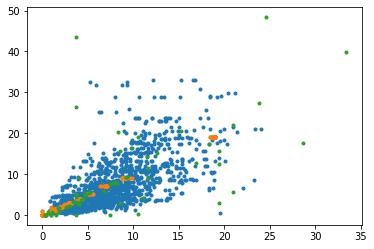

In [17]:
mask1 = X_test['Armour Type'] == 'ROCK'
mask2 = X_test['Armour Type'] == 'XBLOCK'
mask3 = X_test['Armour Type'] == 'HANBAR'

plt.plot(pipe.predict(X_test[mask1]),y_test[mask1], marker = '.', linewidth = 0)
plt.plot(pipe.predict(X_test[mask2]),y_test[mask2], marker = '.', linewidth = 0)
plt.plot(pipe.predict(X_test[mask3]),y_test[mask3], marker = '.', linewidth = 0)

In [18]:
X_test['Armour Type'].unique()

array(['ROCK', 'XBLOCK', 'HANBAR'], dtype=object)

In [33]:
from tensorflow import keras
from keras.layers import Dense, Dropout
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# create a function that returns a model, taking as parameters things you
# want to verify using cross-valdiation and model selection
def create_model(optimizer='adagrad',
                 kernel_initializer='glorot_uniform', 
                 dropout=0.2):
    model = Sequential()
    model.add(Dense(64,activation='relu',kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation='relu',kernel_initializer=kernel_initializer))

    model.compile(loss='mse',optimizer=optimizer, metrics=[keras.metrics.MeanSquaredError(name="mean_squared_error", dtype=None)])

    return model

# wrap the model using the function you created
clf = KerasRegressor(build_fn=create_model,verbose=0)



param_grid = {
    'clf__optimizer':['rmsprop','adam','adagrad'],
    'clf__epochs':[4,8,12,20,50],
    'clf__dropout':[0.1,0.2],
    'clf__kernel_initializer':['glorot_uniform','normal','uniform']
}

pipeline = Pipeline([
    ('preprocess',preproc),
    ('clf',clf)
])



/tmp/ipykernel_7370/2788687049.py:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  clf = KerasRegressor(build_fn=create_model,verbose=0)


In [34]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 FeatureUnion(transformer_list=[('preprocess',
                                                 ColumnTransformer(transformers=[('num_tr',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   RobustScaler())]),
                                                                                  ['Armour '
                                                                                   'Mass '
                                                                                   '[kg]',
                                                                                   'Significant '
                                                                                   'Wave '
                                                                                   'Height '
                                                                                   'at '
                                                                                   'Toe '
                                                                                   '[m]',
                                                                                   'Peak '
                                                                                   'Wave '
                                                                                   'Period '
                                                                                   '[s]',
                                                                                   'Number '
                                                                                   'of '
                                                                                   'Waves '
                                                                                   '[-]',
                                                                                   'Notional '
                                                                                   'Permeability '
                                                                                   '[-]']),
                                                                                 ('cat_tr',
                                                                                  OneHotEncoder(handle_unknown='ig...
                                                                                                 ('depth_toe',
                                                                                                  FunctionTransformer(func=<function <lambda> at 0x7ffc63e63670>)),
                                                                                                 ('structure_height',
                                                                                                  FunctionTransformer(func=<function <lambda> at 0x7ffc63bd7c10>)),
                                                                                                 ('relative_density',
                                                                                                  FunctionTransformer(func=<function <lambda> at 0x7ffc63bd7ca0>))])),
                                                                 ('scaler_custom',
                                                                  RobustScaler())]))])),
                ('clf',
                 <keras.wrappers.scikit_learn.KerasRegressor object at 0x7ffc042a46a0>)])

In [35]:
# if you're not using a GPU, you can set n_jobs to something other than 1
grid = GridSearchCV(pipeline, cv=3, param_grid=param_grid, verbose = 2)
grid.fit(X_train, y_train)

# summaraize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] END clf__dropout=0.1, clf__epochs=4, clf__kernel_initializer=glorot_uniform, clf__optimizer=rmsprop; total time=   0.7s
[CV] END clf__dropout=0.1, clf__epochs=4, clf__kernel_initializer=glorot_uniform, clf__optimizer=rmsprop; total time=   0.7s
[CV] END clf__dropout=0.1, clf__epochs=4, clf__kernel_initializer=glorot_uniform, clf__optimizer=rmsprop; total time=   0.7s
[CV] END clf__dropout=0.1, clf__epochs=4, clf__kernel_initializer=glorot_uniform, clf__optimizer=adam; total time=   1.0s
[CV] END clf__dropout=0.1, clf__epochs=4, clf__kernel_initializer=glorot_uniform, clf__optimizer=adam; total time=   0.6s
[CV] END clf__dropout=0.1, clf__epochs=4, clf__kernel_initializer=glorot_uniform, clf__optimizer=adam; total time=   0.6s
[CV] END clf__dropout=0.1, clf__epochs=4, clf__kernel_initializer=glorot_uniform, clf__optimizer=adagrad; total time=   0.6s
[CV] END clf__dropout=0.1, clf__epochs=4, clf__kernel_initializer=glorot

[CV] END clf__dropout=0.1, clf__epochs=12, clf__kernel_initializer=normal, clf__optimizer=adam; total time=   1.2s
[CV] END clf__dropout=0.1, clf__epochs=12, clf__kernel_initializer=normal, clf__optimizer=adagrad; total time=   1.6s
[CV] END clf__dropout=0.1, clf__epochs=12, clf__kernel_initializer=normal, clf__optimizer=adagrad; total time=   1.4s
[CV] END clf__dropout=0.1, clf__epochs=12, clf__kernel_initializer=normal, clf__optimizer=adagrad; total time=   1.1s
[CV] END clf__dropout=0.1, clf__epochs=12, clf__kernel_initializer=uniform, clf__optimizer=rmsprop; total time=   1.2s
[CV] END clf__dropout=0.1, clf__epochs=12, clf__kernel_initializer=uniform, clf__optimizer=rmsprop; total time=   1.2s
[CV] END clf__dropout=0.1, clf__epochs=12, clf__kernel_initializer=uniform, clf__optimizer=rmsprop; total time=   1.2s
[CV] END clf__dropout=0.1, clf__epochs=12, clf__kernel_initializer=uniform, clf__optimizer=adam; total time=   1.2s
[CV] END clf__dropout=0.1, clf__epochs=12, clf__kernel_ini

[CV] END clf__dropout=0.2, clf__epochs=4, clf__kernel_initializer=glorot_uniform, clf__optimizer=rmsprop; total time=   0.7s
[CV] END clf__dropout=0.2, clf__epochs=4, clf__kernel_initializer=glorot_uniform, clf__optimizer=adam; total time=   0.6s
[CV] END clf__dropout=0.2, clf__epochs=4, clf__kernel_initializer=glorot_uniform, clf__optimizer=adam; total time=   0.6s
[CV] END clf__dropout=0.2, clf__epochs=4, clf__kernel_initializer=glorot_uniform, clf__optimizer=adam; total time=   0.6s
[CV] END clf__dropout=0.2, clf__epochs=4, clf__kernel_initializer=glorot_uniform, clf__optimizer=adagrad; total time=   0.6s
[CV] END clf__dropout=0.2, clf__epochs=4, clf__kernel_initializer=glorot_uniform, clf__optimizer=adagrad; total time=   0.6s
[CV] END clf__dropout=0.2, clf__epochs=4, clf__kernel_initializer=glorot_uniform, clf__optimizer=adagrad; total time=   0.6s
[CV] END clf__dropout=0.2, clf__epochs=4, clf__kernel_initializer=normal, clf__optimizer=rmsprop; total time=   0.7s
[CV] END clf__dro

[CV] END clf__dropout=0.2, clf__epochs=12, clf__kernel_initializer=normal, clf__optimizer=adagrad; total time=   1.1s
[CV] END clf__dropout=0.2, clf__epochs=12, clf__kernel_initializer=uniform, clf__optimizer=rmsprop; total time=   1.2s
[CV] END clf__dropout=0.2, clf__epochs=12, clf__kernel_initializer=uniform, clf__optimizer=rmsprop; total time=   1.3s
[CV] END clf__dropout=0.2, clf__epochs=12, clf__kernel_initializer=uniform, clf__optimizer=rmsprop; total time=   1.3s
[CV] END clf__dropout=0.2, clf__epochs=12, clf__kernel_initializer=uniform, clf__optimizer=adam; total time=   1.3s
[CV] END clf__dropout=0.2, clf__epochs=12, clf__kernel_initializer=uniform, clf__optimizer=adam; total time=   1.2s
[CV] END clf__dropout=0.2, clf__epochs=12, clf__kernel_initializer=uniform, clf__optimizer=adam; total time=   1.2s
[CV] END clf__dropout=0.2, clf__epochs=12, clf__kernel_initializer=uniform, clf__optimizer=adagrad; total time=   1.0s
[CV] END clf__dropout=0.2, clf__epochs=12, clf__kernel_ini

In [40]:
grid.predict(X_test)

array([15.816909 ,  2.703266 , 15.677538 , ...,  0.3965842,  2.9944375,
        2.431551 ], dtype=float32)

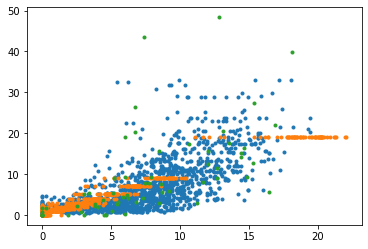

In [41]:
mask1 = X_test['Armour Type'] == 'ROCK'
mask2 = X_test['Armour Type'] == 'XBLOCK'
mask3 = X_test['Armour Type'] == 'HANBAR'

plt.plot(grid.predict(X_test[mask1]),y_test[mask1], marker = '.', linewidth = 0)
plt.plot(grid.predict(X_test[mask2]),y_test[mask2], marker = '.', linewidth = 0)
plt.plot(grid.predict(X_test[mask3]),y_test[mask3], marker = '.', linewidth = 0)

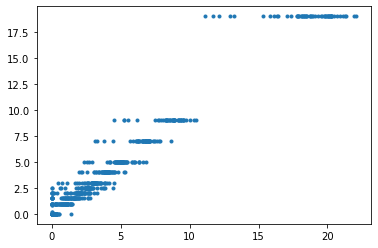

In [42]:
plt.plot(grid.predict(X_test[mask2]),y_test[mask2], marker = '.', linewidth = 0)

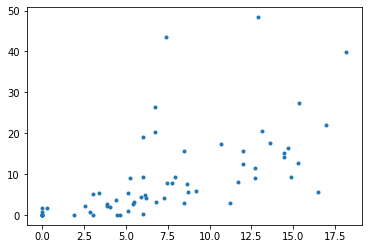

In [43]:
plt.plot(grid.predict(X_test[mask3]),y_test[mask3], marker = '.', linewidth = 0)